In [1]:
import logging
from datetime import datetime, timedelta
import pandas as pd

from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc
from src.data.get_data import YahooFinanceAPI as yfapi
from env import Env


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = (f'{Env.PROJECT_ROOT}/data/03_processed/daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
    },
    'data': {
        'test_size': 0.05,
    },

    'model_name': 'MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04',
}

2023-10-14 03:46:49.472579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 03:46:49.472673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 03:46:49.472707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 03:46:49.484267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # -----------------------------Data----------------------------------------
# df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
# df = FE.create_features(df, logger)
# df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

# df_test_X = df_test.drop(columns=['Adj Close'])
# df_test_X = FE.rename_shifted_columns(df_test_X)
# df_test_y = df_test['Adj Close']

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model_name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

2023-10-14 03:46:51.418000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 03:46:51.426037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 03:46:51.426088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 03:46:51.427547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 03:46:51.427659: I tensorflow/compile

In [3]:
# Get the stock data
today = datetime.today().strftime('%Y-%m-%d')
stock_data_YTD = yfapi.get_daily_data(config['AV']['ticker'], start_date='2023-01-01', end_date=today)
stock_data_df = stock_data_YTD[stock_data_YTD.index > '2023-01-01'][::-1]

df_test_X = stock_data_df[['Adj Close', 'Volume']]
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = stock_data_df['Adj Close']

[*********************100%%**********************]  1 of 1 completed


2023-10-14 03:46:55.133984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


178/178 [==============================] - 3s 5ms/step


2023-10-14 03:46:56.360574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6551924521207605886
2023-10-14 03:46:56 - src.common.plots - INFO - Plot "Predictions MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04-MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.png" saved to "/workspaces/P7-Trading-Bot/figures/Predictions MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04-MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.png"


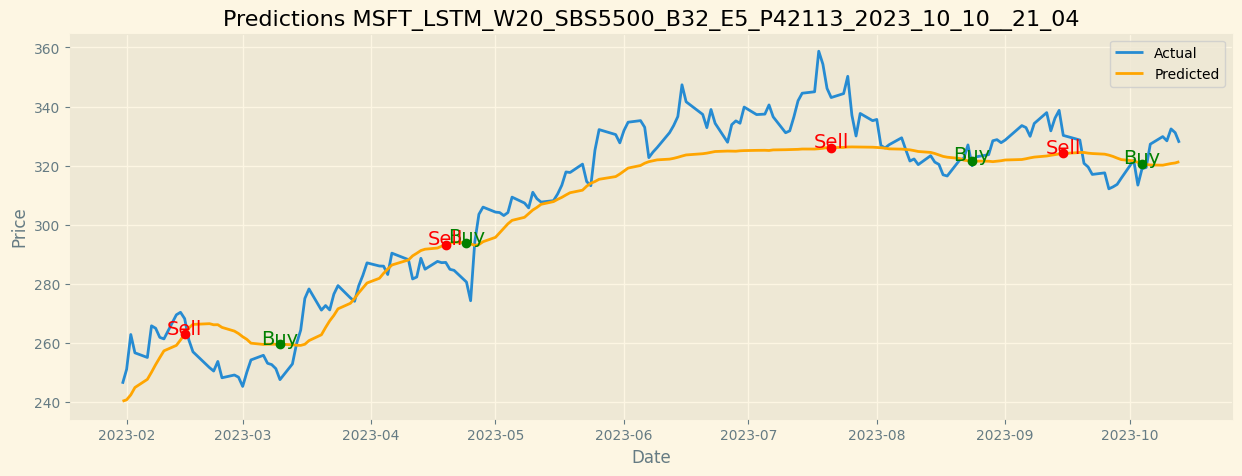

In [4]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)

df_test_plot_y = TFModelService.prep_test_df_shape(df_test_y, window_size)

V.plot_series(  x=df_test_plot_y.index,  # as dates
                y=(df_test_plot_y, results),
                model_name=model._name,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=True,)

In [5]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot_y.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot_y, results, naive_forecast)
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

NameError: name 'df' is not defined